# Importing Packages

In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Reading file to DF and convert strings to categorical code

In [3]:
def readFile2Dataframe(colpath, train_datapath, test_datapath=None):
    with open(colpath) as file:
        columns = [x.strip() for x in file.readline().split(',')]
        
    data = pandas.read_csv(train_datapath, sep=",", header=None, skipinitialspace=True, names=columns)
    
    if test_datapath is not None:
        train_data = data
        test_data = pandas.read_csv(test_datapath, sep=",", header=None, skipinitialspace=True, names=columns)
    else:
        train_data, test_data = train_test_split(data, test_size=0.33, random_state=219366)
        
    return train_data, test_data

In [4]:
def convertCategorical2Catcode(data, columns):
    data = data[columns].apply(lambda x: pandas.factorize(x)[0])
    return data

# MAGIC Gamma Telescope data

In [5]:
df_train, df_test = readFile2Dataframe("data/MAGIC_Gamma_Telescope/magic04.colnames", "data/MAGIC_Gamma_Telescope/magic04.data", None)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12743 entries, 5646 to 11049
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   12743 non-null  float64
 1   fWidth    12743 non-null  float64
 2   fSize     12743 non-null  float64
 3   fConc     12743 non-null  float64
 4   fConc1    12743 non-null  float64
 5   fAsym     12743 non-null  float64
 6   fM3Long   12743 non-null  float64
 7   fM3Trans  12743 non-null  float64
 8   fAlpha    12743 non-null  float64
 9   fDist     12743 non-null  float64
 10  class     12743 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.2+ MB


In [7]:
df_train.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,12743.000000,12743.000000,12743.000000,12743.000000,12743.000000,12743.000000,12743.000000,12743.000000,12743.000000,12743.000000
mean,53.147899,22.139425,2.820696,0.381813,0.215487,-4.388506,10.138320,0.336658,27.662014,193.763589
std,42.428865,18.320887,0.470384,0.182689,0.110399,59.482194,50.831227,20.711623,25.906328,74.930456
min,4.283500,0.000000,1.941300,0.013900,0.007300,-457.916100,-318.300200,-164.140000,0.000000,5.745600
25%,24.201100,11.838150,2.473500,0.237500,0.129300,-20.528450,-13.243250,-10.796750,5.796450,142.667950
50%,36.862100,17.066800,2.736400,0.356200,0.197800,3.596400,14.979900,0.551600,17.978900,191.395000
75%,69.995400,24.726050,3.096900,0.504450,0.286000,23.797900,35.115200,10.948550,45.607750,239.973000
max,334.177000,256.382000,5.011800,0.893000,0.675200,575.240700,238.321000,170.692000,90.000000,495.561000


In [8]:
df_train[["class"]] = convertCategorical2Catcode(df_train, ["class"])
df_test[["class"]]  = convertCategorical2Catcode(df_test, ["class"])

In [9]:
X_train = df_train.drop(columns=["class"])
y_train = df_train["class"]

X_test = df_test.drop(columns=["class"])
y_test = df_test["class"]

In [10]:
y_train

5646     0
8880     0
11404    0
8974     0
1521     0
        ..
7998     0
15534    1
9305     0
11902    0
11049    0
Name: class, Length: 12743, dtype: int64

# Pipeline


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import sqrt

from mlxtend.evaluate import mcnemar_table, paired_ttest_5x2cv

from sklearn.metrics import  accuracy_score, f1_score

### Confidence interval:

$$ a\pm t_{\alpha,k-1 }\frac{s}{\sqrt{k}} $$

Where:
 - $a$ is the average of the accuracies across the kfolds
 - $s$ is the variance of the accuracies across the kfolds
 - $k$ is the number of k_folds
 - $t_{\alpha,k-1 }$, is the t-score value - 2.262156, for a 95% confidence level




In [12]:
#plot confidence intervals following the t-score of the various models tested in the k-fold cross validation of the grid search
def plot_confidence_interval(mean, stdev, params, t = 2.262156, k = 10, horizontal_line_width=0.25):
    '''
    Plots different confidence intervals of various models tested in the k-folds cross validation grid search.


    :param mean: array containing the average scores of the different models
    :param stdev: array containing the standard deviations scores of the different models
    :param params: array of the parameters tested
    :param t: the t-score to generate the confidence interval around
    :param k: the number of folds executed
    :param horizontal_line_width: width of the horizontal line
    :return: None
    '''

    legend = []
    plt.figure(figsize=(13, 13))

    for i in range(1,len(mean)+1):
        color = np.random.rand(3,) #generate a color for each line

        confidence_interval =  t*((stdev[i-1]*100)**2 /sqrt(k-1)) #create the confidence interval

        left = i - horizontal_line_width / 2
        top = mean[i-1]*100 - confidence_interval
        right = i + horizontal_line_width / 2
        bottom = mean[i-1]*100 + confidence_interval

        #plot the lines
        plt.plot([i, i], [top, bottom], color=color)
        plt.plot([left, right], [top, top], color=color)
        plt.plot([left, right], [bottom, bottom], color=color)
        plt.plot(i, mean[i-1]*100, 'o', color=color)
        #add the parameters to the legend
        legend.append(mpatches.Patch(color = color, label=f"{i}: {params[i-1]}"))

    plt.xticks(range(1,len(mean)+1))
    plt.legend(handles=legend,bbox_to_anchor=(1.04,1), loc="upper left")
    plt.ylabel('Test F1 score')
    plt.xlabel('Test number')
    plt.title('Confidence Interval')
    plt.title('95% Confidence Interval of the cross validation of the grid search results')


### Pipeline

We use gridsearch to select the optimal model parameters for the model and dataset.

We use F1-Score as the main model metric, as it is generally better than the accuracy score, as we have some imbalanced datasets. We also use AUC score as a substitute for accuracy in this case as it uses probabilities of FPR and TPR.

In [13]:
def pipeline(X, y, model, param_grid, k = 10, t = 2.262156):
    scoring = {"AUC": "roc_auc", "F1": "f1"}

    gs = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring=scoring,
        refit="F1",
        return_train_score=True,
        n_jobs=-1,
        cv=k
    )

    print("=============================================================")
    print(f"MODEL: {type(model).__name__}")
    gs.fit(X, y)
    results = gs.cv_results_

    print("=============================================================")
    print(f"BEST PARAMETERS: {gs.best_params_}")
    print("=============================================================")
    print(f"BEST MODEL RESULTS:")
    print(f"MEAN TRAIN F1-SCORE: {results['mean_train_F1'][gs.best_index_]}")
    print(f"MEAN TRAIN AUC SCORE: {results['mean_train_AUC'][gs.best_index_]}")
    print(f"MEAN TEST F1-SCORE: {results['mean_test_F1'][gs.best_index_]}")
    print(f"MEAN TEST AUC SCORE: {results['mean_test_AUC'][gs.best_index_]}")
    confidence_interval =  t*((results['std_test_F1'][gs.best_index_]*100)**2 /sqrt(k-1))
    print(f"TEST F1-SCORE CONFIDENCE INTERVAL: {results['mean_test_F1'][gs.best_index_]*100-confidence_interval},{results['mean_test_F1'][gs.best_index_]*100+confidence_interval}")
    print("=============================================================")

    plot_confidence_interval(results['mean_test_F1'], results['std_test_F1'], results['params'], k=k, t =t)

    plt.show()

    return results, gs


### Model Evaluator

We then evaluate the best model picked by the grid search, and determine its accuracy and F1-score on train and test data, aswell as show its confidence intervals in accordance with a 95% z-score

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

def model_evaluator(model,X_train,y_train,X_test,y_test, z= 1.96, k=10,  t = 2.262156):
    '''
    Used to train and evaluate a model
    :param model: model to be evlauated
    :param X_train:
    :param y_train:
    :param X_test:
    :param y_test:
    :param z: Z-score to generate a confidence interval
    :return: The predicted values on the test set
    '''

    model2 = model



    print(f"Performing training for {k}-fold Cross Validation:")
    #train the model
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    kf = KFold(n_splits=k)
    cv = cross_validate(model2,X,y, scoring=("f1", "accuracy") ,cv=k)

    stdev = np.std(cv['test_accuracy'])
    acc = np.mean(cv['test_accuracy'])*100
    confidence_interval =  t*((stdev*100)**2 /sqrt(k-1))
    print(f"CV ACCURACY:{acc:.3f} CONFIDENCE INTERVAL: {(acc-confidence_interval)},{(acc+confidence_interval)}")

    stdev = np.std(cv['test_f1'])
    f1 = np.mean(cv['test_f1'])*100
    confidence_interval =  t*((stdev*100)**2 /sqrt(k-1))
    print(f"CV F1-SCORE:{f1:.3f} CONFIDENCE INTERVAL: {(f1-confidence_interval)},{(f1+confidence_interval)}")




    print("Performing training for Holdout:")
    #train the model
    model.fit(X_train, y_train)
    #predict the test set
    y_pred = model.predict(X_test)
    #get the accuracy, although it is not the best metric
    acc = accuracy_score(y_test, y_pred)
    #generate the confidence interval
    confidence_interval =  z*sqrt(acc*(1-acc)/len(y_test))
    print(f"TEST ACCURACY:{acc*100:.3f} CONFIDENCE INTERVAL: {(acc-confidence_interval)*100},{(acc+confidence_interval)*100}")
    #get the f1-score
    f1 = f1_score(y_test, y_pred)
    confidence_interval =  z*sqrt(f1*(1-f1)/len(y_test))
    print(f"TEST F1-SCORE:{f1*100:.3f} CONFIDENCE INTERVAL: {(f1-confidence_interval)*100},{(f1+confidence_interval)*100}")




    return y_pred


### Compare Models

In [15]:
def model_comparer(model1, model2, X_train, y_train, X_test, y_test):
    '''
    Designeed to compare 2 models to identify if they are statistically similar
    :param model1: The first model
    :param model2: The second model
    :param X_test: The dataset to test on
    :param y_test: The scores to test the models on
    :return: None
    '''

    print("=============================================================")
    print(f"TRAINING MODEL 1: {type(model1).__name__}")
    model1.fit(X_train, y_train)
    print("=============================================================")
    print(f"TRAINING MODEL 2: {type(model2).__name__}")
    model2.fit(X_train, y_train)
    y_model1 = model1.predict(X_test)
    y_model2 = model2.predict(X_test)

    print("=============================================================")
    print(f"MODEL 1: {type(model1).__name__}, ACCURACY: {accuracy_score(y_test, y_model1)*100:.3f}, F1-SCORE: {f1_score(y_test, y_model1)*100:.3f}")
    print(f"MODEL 2: {type(model2).__name__}, ACCURACY: {accuracy_score(y_test, y_model2)*100:.3f}, F1-SCORE: {f1_score(y_test, y_model2)*100:.3f}")
    print("=============================================================")
    print("MCNEMAR TABLE:")

    mc_table = mcnemar_table(y_test, y_model1, y_model2)

    labels = ["Predicted Correct", "Predicted Incorrect"]
    ax = sns.heatmap(mc_table, annot=True,fmt='g', yticklabels = labels, xticklabels=labels)
    ax.set(xlabel=type(model2).__name__, ylabel=type(model1).__name__, title="McNemar Table" )
    ax.set()
    plt.show()

    chisq = (mc_table[0][1] - mc_table[1,0])**2/(mc_table[0][1]+mc_table[1][0])

    print(mc_table)
    print("=============================================================")
    print(f"CHI-SQUARED TEST OF MCNEMAR TABLE: {chisq:.3f}")
    if chisq>3.841:
        print("Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.")
    else:
        print("Since the Chi-Square is above the threshhold of 3.841, we accept the null hypothesis, showing the models are similar.")
    print("=============================================================")
    print("5x2 CV PAIRED T-TEST:")
    print("=============================================================")

    paired_tttest1 = paired_ttest_5x2cv(model1, model2, X_train, y_train, scoring=None, random_seed = 12345678)
    print(f"USING ACCURACY SCORE: T:{paired_tttest1[0]:.3f} P:{paired_tttest1[1]:.3f}")
    if paired_tttest1[1]<0.05:
        print("Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.")
    else:
        print("Since the P-test is above the threshhold of 0.05, we accept the null hypothesis, showing the models are similar.")
    paired_tttest2 = paired_ttest_5x2cv(model1, model2, X_train, y_train, scoring="f1", random_seed = 12345678)
    print(f"USING F1-SCORE: T:{paired_tttest2[0]:.3f} P:{paired_tttest2[1]:.3f}")
    if paired_tttest2[1]<0.05:
        print("Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.")
    else:
        print("Since the P-test is above the threshhold of 0.05, we accept the null hypothesis, showing the models are similar.")
    print("=============================================================")





    return

## Model Fitting - KNN

In [16]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

MODEL: KNeighborsClassifier
BEST PARAMETERS: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}
BEST MODEL RESULTS:
MEAN TRAIN F1-SCORE: 0.6870671092263197
MEAN TRAIN AUC SCORE: 0.8990073464413655
MEAN TEST F1-SCORE: 0.6677334751085794
MEAN TEST AUC SCORE: 0.8652889875262646
TEST F1-SCORE CONFIDENCE INTERVAL: 64.4118086442624,69.1348863774535


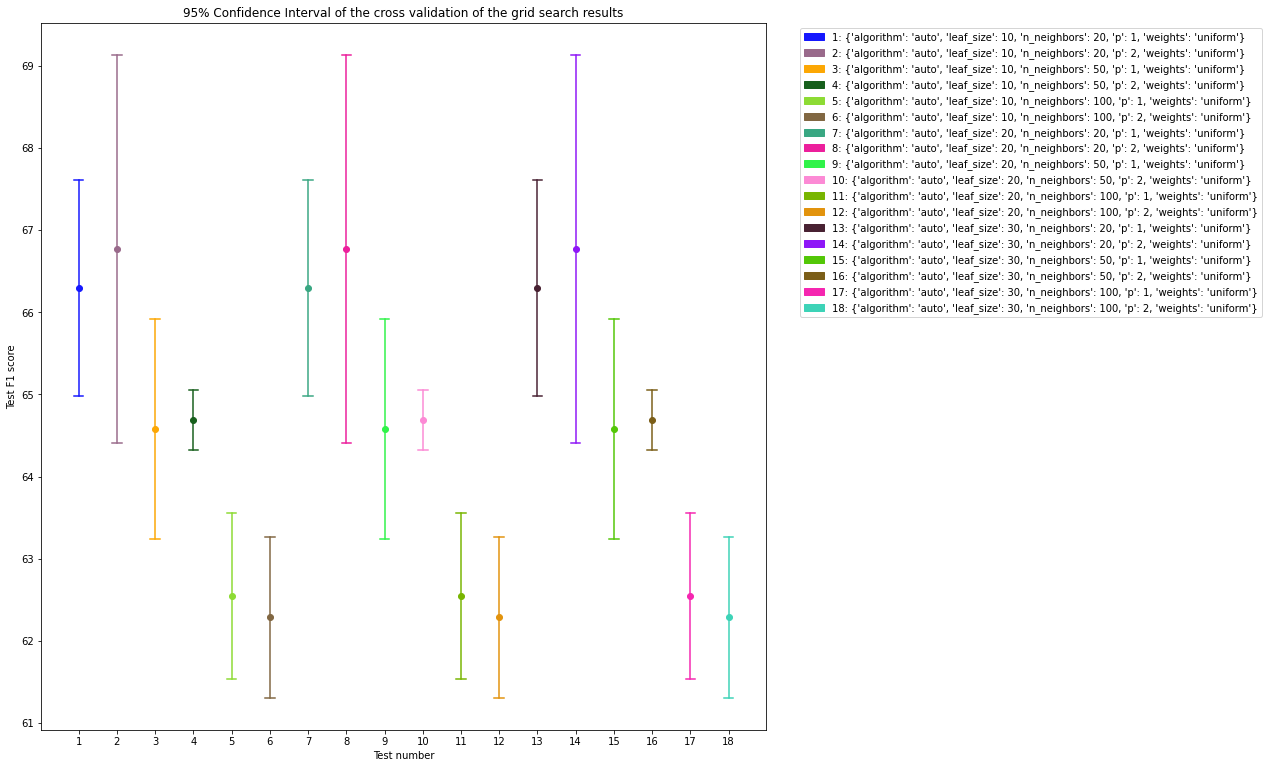

In [17]:

from sklearn.neighbors import KNeighborsClassifier

#todo add more paramaeters
param_grid = [
    {'p': [1,2],                       # p = 1 use manhattan_distance power parameter for Minkowski metric
    'n_neighbors': [20,50,100],
    'leaf_size':[10,20,30],
    'weights': ['uniform'],
    'algorithm':['auto']},
 ]

neigh = KNeighborsClassifier()


results, gs_neigh = pipeline(X, y, neigh, param_grid)

In [18]:
#create a model with the optimal paarameters
neigh = KNeighborsClassifier(**gs_neigh.best_params_)
#evaluate the model
neigh_y_pred = model_evaluator(neigh, X_train,y_train,X_test, y_test)

Performing training for 10-fold Cross Validation:
CV ACCURACY:81.167 CONFIDENCE INTERVAL: 80.62533279507652,81.70905206296764
CV F1-SCORE:66.773 CONFIDENCE INTERVAL: 64.4118086442624,69.1348863774535
Performing training for Holdout:
TEST ACCURACY:80.405 CONFIDENCE INTERVAL: 79.42268446661578,81.38661934093561
TEST F1-SCORE:65.037 CONFIDENCE INTERVAL: 63.85727139854327,66.21663422965456


## Model Fitting - XGBoost

MODEL: XGBClassifier
BEST PARAMETERS: {'colsample_bytree': 0.5, 'gamma': 3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 10, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.5}
BEST MODEL RESULTS:
MEAN TRAIN F1-SCORE: 0.8707605361834657
MEAN TRAIN AUC SCORE: 0.9676443765316408
MEAN TEST F1-SCORE: 0.8193008722979691
MEAN TEST AUC SCORE: 0.9344678624347477
TEST F1-SCORE CONFIDENCE INTERVAL: 81.10178732331346,82.75838713628036


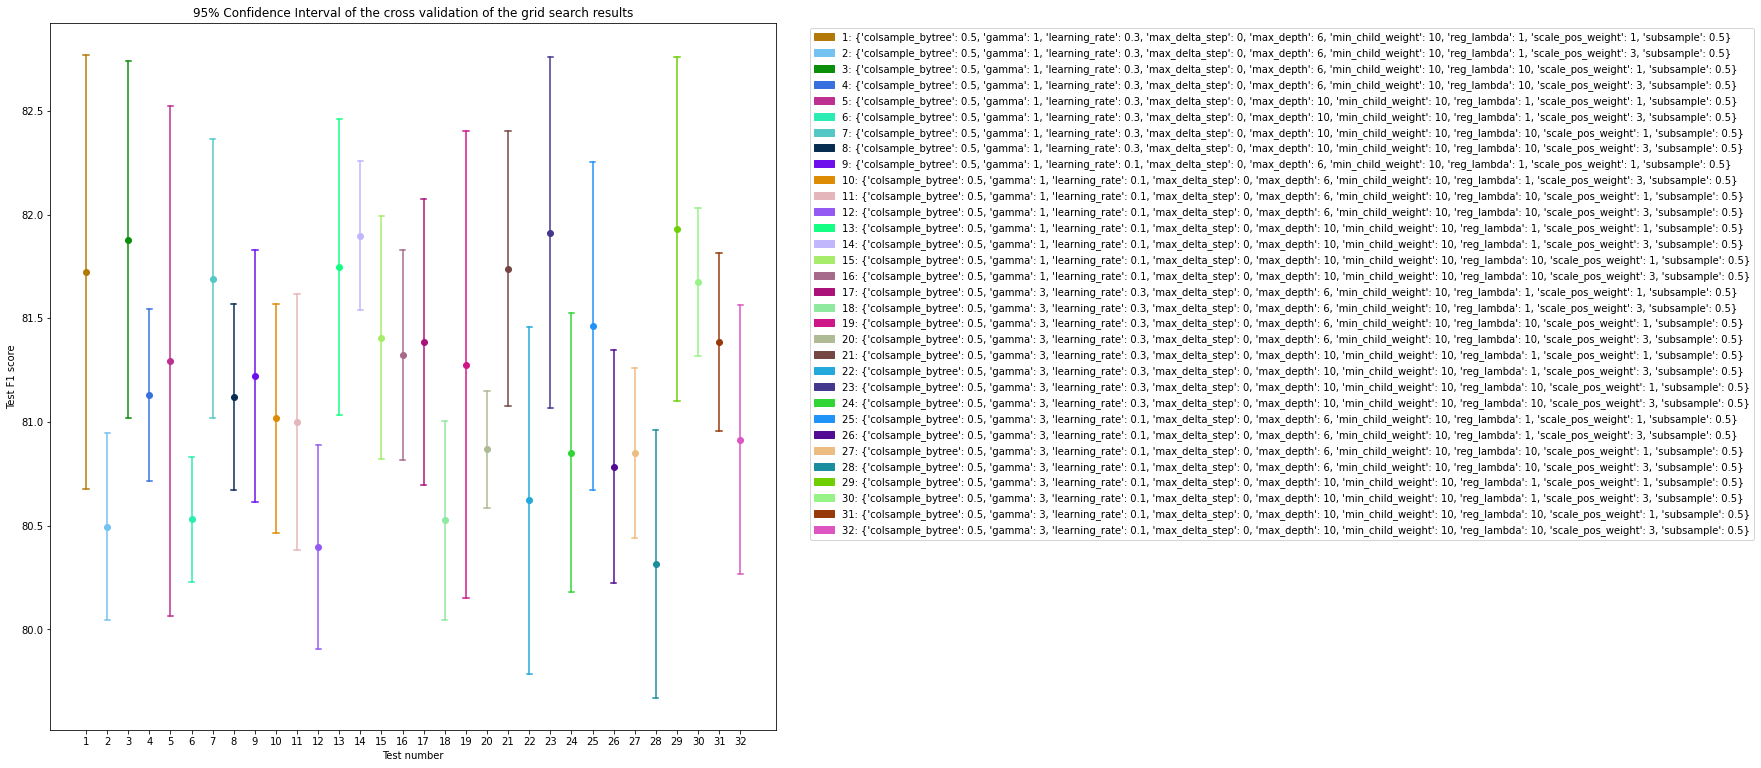

In [19]:

import xgboost as xgb



#todo add more paramaeters
# param_grid = {
#     "learning_rate": [0,1]," 
#     "max_depth": [6, 10],
#     "learning_rate": [0.5, 0.3, 0.1],
#     "gamma": [1, 3],
#     # "reg_lambda": [0, 1, 10], def 1, pref 10
#     "scale_pos_weight": [1, 3, 5], #proportion of negative/positive
#     "subsample": [0.5],
#     "colsample_bytree": [0.5],
# }

param_grid = {
    "learning_rate": [0,1],     # shrinks the features weights to prevent overfitting
    "max_depth": [6,10],        #depth of the tree, increases complexity of the model
    "learning_rate": [0.3,0.1],
    "gamma": [1,3],             #minimum loss required to split the tree
    "reg_lambda": [1,10],       #l2 reg weights
    "scale_pos_weight": [1,3],  #proportion of negative/positive
    "subsample": [0.5],         #proportion to subsample the train data
    "colsample_bytree": [0.5],
    "min_child_weight":[10],
    "max_delta_step":[0]
}


xgb_cl = xgb.XGBClassifier()


results, xgb_gs = pipeline(X, y, xgb_cl, param_grid)

In [20]:
#create a model with the optimal paarameters
xgb_cl = xgb.XGBClassifier(**xgb_gs.best_params_)
#evaluate the model
xgb_y_pred = model_evaluator(xgb_cl, X_train,y_train,X_test, y_test)



Performing training for 10-fold Cross Validation:
CV ACCURACY:88.091 CONFIDENCE INTERVAL: 87.79706168779114,88.38590361189338
CV F1-SCORE:81.930 CONFIDENCE INTERVAL: 81.10178732331346,82.75838713628036
Performing training for Holdout:
TEST ACCURACY:87.144 CONFIDENCE INTERVAL: 86.315486575897,87.97159323930136
TEST F1-SCORE:80.322 CONFIDENCE INTERVAL: 79.33834001664026,81.30540541130415


TRAINING MODEL 1: XGBClassifier
TRAINING MODEL 2: KNeighborsClassifier
MODEL 1: XGBClassifier, ACCURACY: 87.144, F1-SCORE: 80.322
MODEL 2: KNeighborsClassifier, ACCURACY: 80.405, F1-SCORE: 65.037
MCNEMAR TABLE:


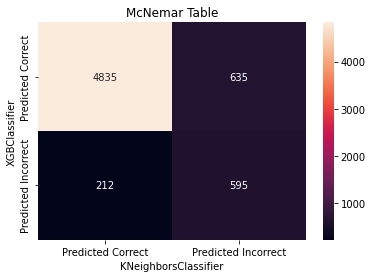

[[4835  635]
 [ 212  595]]
CHI-SQUARED TEST OF MCNEMAR TABLE: 211.250
Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.
5x2 CV PAIRED T-TEST:
USING ACCURACY SCORE: T:19.474 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.
USING F1-SCORE: T:25.582 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.


In [21]:
model_comparer(xgb_cl, neigh, X_train, y_train , X_test, y_test)

## Model Fitting ADABoost

MODEL: AdaBoostClassifier
BEST PARAMETERS: {'n_estimators': 500}
BEST MODEL RESULTS:
MEAN TRAIN F1-SCORE: 0.796579378328264
MEAN TRAIN AUC SCORE: 0.923402494402826
MEAN TEST F1-SCORE: 0.7721259234926335
MEAN TEST AUC SCORE: 0.9035170552237967
TEST F1-SCORE CONFIDENCE INTERVAL: 75.60943550837418,78.81574919015254


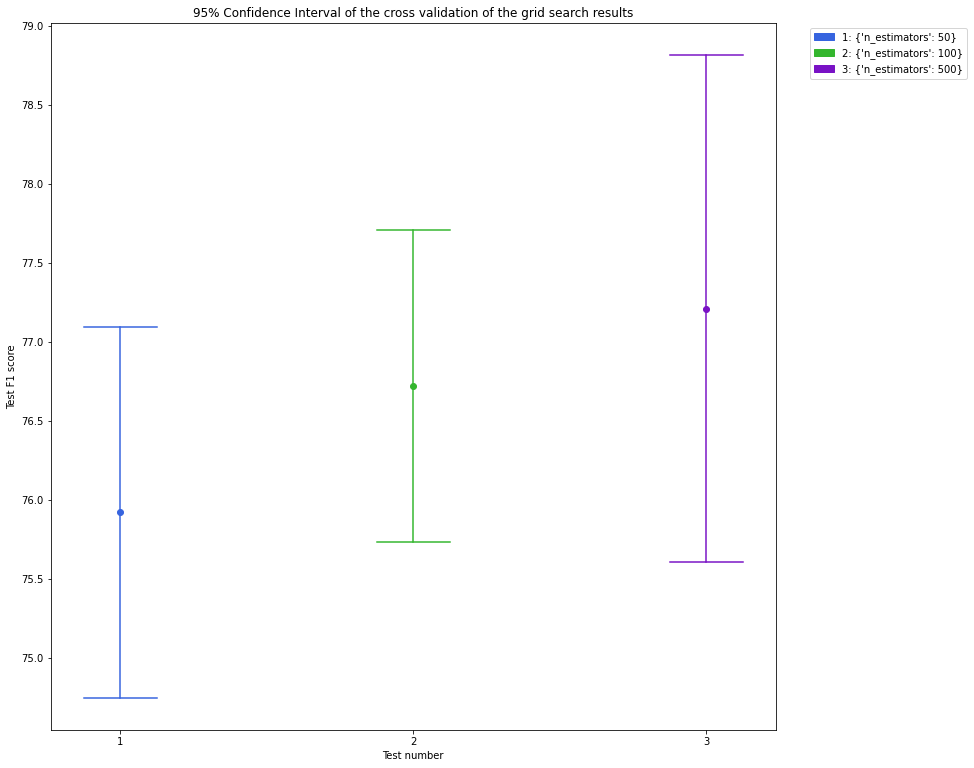

In [22]:
from sklearn.ensemble import AdaBoostClassifier

AdaBoostClassifier


param_grid = {
    "n_estimators":[50,100,500]
}


ada_cl = AdaBoostClassifier()


results, ada_gs = pipeline(X, y, ada_cl, param_grid)


In [23]:
#create a model with the optimal paarameters
ada_cl = AdaBoostClassifier(**ada_gs.best_params_)
#evaluate the model
ada_y_pred = model_evaluator(ada_cl, X_train,y_train,X_test, y_test)



Performing training for 10-fold Cross Validation:
CV ACCURACY:84.874 CONFIDENCE INTERVAL: 84.39646946288207,85.35116460651858
CV F1-SCORE:77.213 CONFIDENCE INTERVAL: 75.60943550837418,78.81574919015254
Performing training for Holdout:
TEST ACCURACY:84.228 CONFIDENCE INTERVAL: 83.32645924660768,85.12980967166537
TEST F1-SCORE:75.842 CONFIDENCE INTERVAL: 74.78294675951823,76.90080141032072


TRAINING MODEL 1: AdaBoostClassifier
TRAINING MODEL 2: KNeighborsClassifier
MODEL 1: AdaBoostClassifier, ACCURACY: 84.228, F1-SCORE: 75.842
MODEL 2: KNeighborsClassifier, ACCURACY: 80.405, F1-SCORE: 65.037
MCNEMAR TABLE:


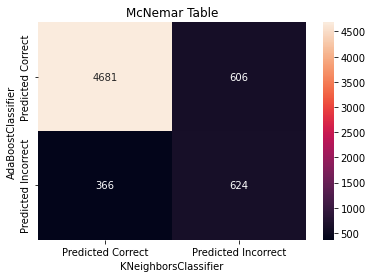

[[4681  606]
 [ 366  624]]
CHI-SQUARED TEST OF MCNEMAR TABLE: 59.259
Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.
5x2 CV PAIRED T-TEST:
USING ACCURACY SCORE: T:10.750 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.
USING F1-SCORE: T:22.530 P:0.000
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.


In [24]:
model_comparer(ada_cl, neigh, X_train, y_train, X_test, y_test)

TRAINING MODEL 1: XGBClassifier
TRAINING MODEL 2: AdaBoostClassifier
MODEL 1: XGBClassifier, ACCURACY: 87.144, F1-SCORE: 80.322
MODEL 2: AdaBoostClassifier, ACCURACY: 84.228, F1-SCORE: 75.842
MCNEMAR TABLE:


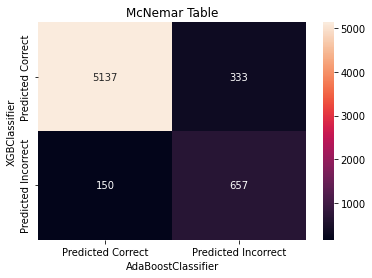

[[5137  333]
 [ 150  657]]
CHI-SQUARED TEST OF MCNEMAR TABLE: 69.335
Since the Chi-Square is above the threshhold of 3.841, we reject the null hypothesis, showing the models are significantly different.
5x2 CV PAIRED T-TEST:
USING ACCURACY SCORE: T:3.970 P:0.011
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.
USING F1-SCORE: T:3.248 P:0.023
Since the P-test is below the threshhold of 0.05, we reject the null hypothesis, showing the models are significantly different.


In [25]:
model_comparer(xgb_cl, ada_cl, X_train, y_train, X_test, y_test)

# Conclusion

- All three of the models are significantly worse on the f1-score than accuracy scores.
- XGboost was better on both accuracy and f1 score when comparing XGboost and adaboost.
- When comparing them to KNN, they are both signifcantly better in f1-score, and accuracy.
- We compared the models in pairs (XG, KNN), (Ada, KNN), (XG, Ada) using CHI-SQUARED and 5x2 CV PAIRED test and found that model pairs are significantly different.

